## Open and pre-select data

In [1]:
#Import functions------------------------------------------------------------------------------------------------------
from my_functions import*
#Open Zmumu file
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") 
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

#Set event range
nmin1=0
nmax1=5000

#Choose quality 0
Zmumu_pt=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_pt"].array(),0)[nmin1:nmax1]
Zmumu_eta=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_eta"].array(),0)[nmin1:nmax1]
Zmumu_phi=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_phi"].array(),0)[nmin1:nmax1]
#Select the Z peak pairs
Zmumu_pt, Zmumu_eta, Zmumu_phi= get_all_Z_peak_pairs(Zmumu_pt,Zmumu_eta,Zmumu_phi)

#Open ZeroBias file
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/zbV3_skim.root") 
MuonTree_ZeroBias=file["MuonTree;1"]

#Apply energy cut to offline
ZeroBias_pt=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array())
ZeroBias_eta=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array())
ZeroBias_phi=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array())

#Get online data
Zbl1_pt=MuonTree_ZeroBias["LVL1Muon_et"].array() * 1000
Zbl1_eta=MuonTree_ZeroBias["LVL1Muon_eta"].array()
Zbl1_phi=MuonTree_ZeroBias["LVL1Muon_phi"].array()

#Create mask matching offline and LVL1
mask=offline_LVL1_matcher(ZeroBias_eta, ZeroBias_phi, Zbl1_eta, Zbl1_phi)

#Apply mask
ZeroBias_pt=ZeroBias_pt[mask]
ZeroBias_eta=ZeroBias_eta[mask]
ZeroBias_phi=ZeroBias_phi[mask]


100%|██████████| 5000/5000 [00:06<00:00, 788.14it/s]
494957it [02:14, 3666.74it/s]


## Plot pt, eta, phi

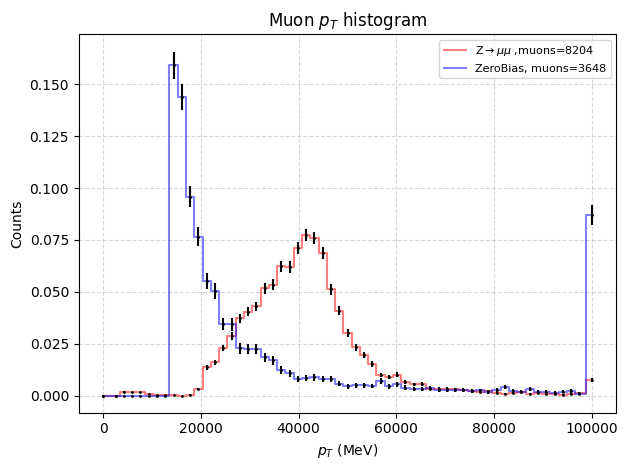

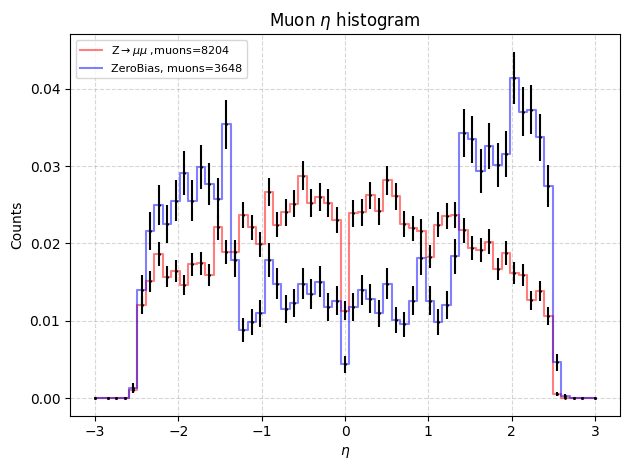

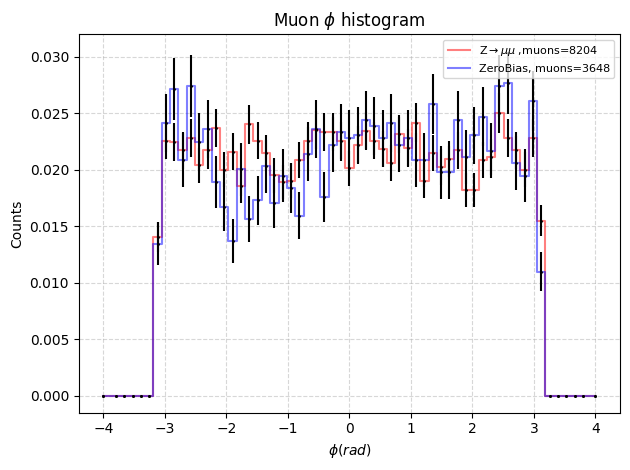

In [2]:
l1=len(ak.flatten(Zmumu_pt))
l2=len(ak.flatten(ZeroBias_pt))
coolplot([Zmumu_pt, ZeroBias_pt], np.linspace(0,10*10**4, 60),
          labels=[rf"Z$\to \mu\mu$ ,muons={l1}", f"ZeroBias, muons={l2}"], title="Muon $p_T$ histogram", x_label=r"$p_T$ (MeV)", y_label="Counts")
coolplot([Zmumu_eta, ZeroBias_eta], np.linspace(-3,3, 60),
         labels=[rf"Z$\to \mu\mu$ ,muons={l1}", f"ZeroBias, muons={l2}"], title=r"Muon $\eta$ histogram", x_label=r"$\eta$", y_label="Counts")
coolplot([Zmumu_phi, ZeroBias_phi], np.linspace(-4,4, 60),
          labels=[rf"Z$\to \mu\mu$ ,muons={l1}", f"ZeroBias, muons={l2}"], title=r"Muon $\phi$ histogram",  x_label=r"$\phi (rad)$", y_label="Counts")

## Compute and plot isolation

In [ ]:

fig2, axis2 = plt.subplots(2, 2, figsize=(12, 8))
fig3, axis3 = plt.subplots(2, 2, figsize=(12, 8))
fig4, axis4 = plt.subplots(1, 1, figsize=(8, 5))
#Set delta R - array length must be even in order to display subplots nicely
dr_mins=[0.10, 0.10, 0.10, 0.10]
dr_maxs=[0.30, 0.40, 0.60, 0.80]
#Set noise cut scaling factors
scalings=[0.0, 0.5, 1.0, 1.5]

#Loop over scalings
for j in range(len(scalings)):  
    #Loop over all dr valuesit="Scalin
    for i in range(len(dr_mins)):  
        dr_min=dr_mins[i]
        dr_max=dr_maxs[i]
        #Compute isolation energy
        res1=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max,
                                        event_range=[nmin1, nmax1], scaling=scalings[j])
        res2=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, 
                                    event_range=[0, len(ZeroBias_eta)], scaling=scalings[j])
        #Plot it
        bins=np.linspace(0,20*10**3,40)
        row, col = divmod(i, 2)
        ax = axis2[row][col]

        aux=ak.flatten(res1)
        l1=len(aux[~np.isnan(aux)])
        aux=ak.flatten(res2)
        l2=len(aux[~np.isnan(aux)])

        coolplot(
            [res1, res2],
            bins=bins,
            labels=[f"Zmumu, muons={l1}", f"ZeroBias, muons={l2}"],
            x_label=r"$E_{iso}$ (MeV)",
            y_label="Counts",
            title=fr"Isolation energy, $\Delta$ R = [{dr_min}, {dr_max}], scaling={scalings[j]}",
            ax=ax)
        
        #Compute ratios
        fig2.tight_layout()
        ratio1=ak.flatten(res1)/ak.flatten(Zmumu_pt)
        ratio1=ratio1[~np.isnan(ratio1)]
        l1=len(ratio1)

        ratio2=ak.flatten(res2)/ak.flatten(ZeroBias_pt)
        ratio2=ratio2[~np.isnan(ratio2)]
        l2=len(ratio2)

        #Plot them
        bins=np.linspace(0,3.0,40)
        row, col = divmod(i, 2)
        ax = axis3[row][col]
        
        coolplot(
        [ratio1, ratio2],
        bins=bins,
        labels=[f"Zmumu, muons={l1}", f"ZeroBias, muons={l2}"],
        x_label=r"$\frac{E_{iso}}{E_{t}}$ (MeV)",
        y_label="Counts",
        title=fr"$\frac{{E_{{iso}}}}{{E_{{t}}}}$ Ratio, $\Delta$ R = [{dr_min}, {dr_max}], scaling={scalings[j]}",
        ax=ax)

        fig3.tight_layout()

        #Compute ROC
        bins=np.linspace(0,2,2000)

        data1=ratio1
        data1=data1[~np.isnan(data1)]
        data2=ratio2
        data2=data2[~np.isnan(data2)]
        Zmumu_counts, _ = np.histogram(data1, bins)
        ZeroBias_counts, _ = np.histogram(data2, bins)
        #Compute the cumulative sum of the counts (like integrating the histogram to the left)
        Zmumu_cumulative_counts = np.cumsum(Zmumu_counts)
        ZeroBias_cumulative_counts = np.cumsum(ZeroBias_counts)
        # Normalize to total events
        TPR = Zmumu_cumulative_counts / np.sum(Zmumu_counts)
        FPR = ZeroBias_cumulative_counts / np.sum(ZeroBias_counts)

        #Plot ROC
        FPR90=min(FPR[TPR >= 0.9])
        ax=axis4
        plt.scatter(FPR, TPR, marker='.', label=fr'$\Delta R=$[{dr_min, dr_max}, scaling={scalings[j]}, FPR90={np.round(FPR90,3)}')
        plt.plot([0,1],[0,1], color='black', linestyle='--')
        plt.plot([0,1],[0.9,0.9],color='r', linestyle='--')
        plt.grid(alpha=0.5, linestyle='--')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.legend()
        plt.title(rf"ROC curves")
        plt.tight_layout()

muon_isolation_all_events: Computing muon isolation:   0%|          | 0/1 [00:00<?, ?it/s]          

In [ ]:
mu=MuonTree_ZeroBias["AverageMu"].array()
l=len(ak.flatten(mu))
coolplot([mu], np.linspace(0,100,40), labels=[f"ZeroBias, muons={l}"], title=r"Average $\mu$", x_label=r"$\mu$", y_label="Counts", colors=['b'])

Heatmap